For now, we don't need to stream everything. We will start off with a single repeating lattice. First we make the lattice

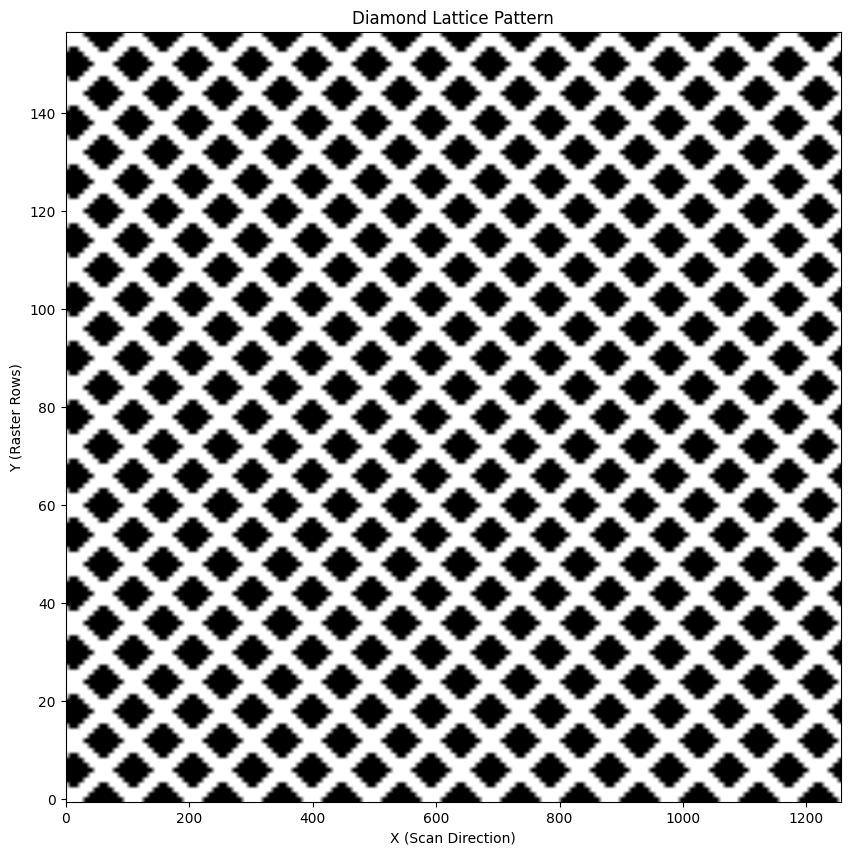

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Settings for printing
sampling_rate = 20_000_000  # 100 MHz
line_duration_us = 157
samples_per_line = sampling_rate * line_duration_us // 2_500_000

# Width and height for viewing purposes
height, width = 157, 157
pattern = np.zeros((height, width))

# Thicker lines — increase to make lines wider
line_spacing = 12
line_thickness = 4

# Generate diamond lattice pattern
for y in range(height):
    for x in range(width):
        if abs((x + y) % line_spacing) < line_thickness or abs((x - y) % line_spacing) < line_thickness:
            pattern[y, x] = 1.0

# Interpolate each row to match the scan resolution
waveform_rows = []
for row in pattern:
    original_indices = np.linspace(0, 1, width)
    target_indices = np.linspace(0, 1, samples_per_line)
    active_row = np.interp(target_indices, original_indices, row).astype(np.float64)
    waveform_rows.append(active_row)

# Show the final pattern visually
plt.figure(figsize=(10, 10))
plt.imshow(waveform_rows, cmap='gray', aspect='auto', origin='lower')
plt.title("Diamond Lattice Pattern")
plt.xlabel("X (Scan Direction)")
plt.ylabel("Y (Raster Rows)")
plt.grid(False)
plt.show()

We need to do some sample redistribution in order to correct for the sinusoidal velocity of the mirror

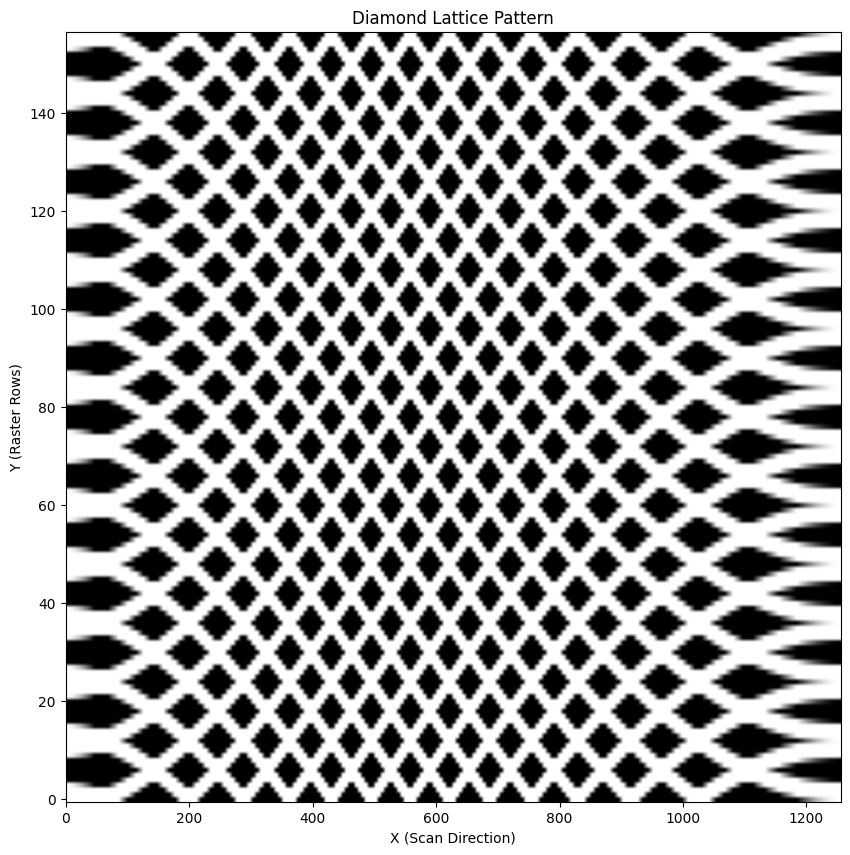

In [68]:
# Interpolate each row with sinusoidal-like sample redistribution
waveform_rows = []
original_indices = np.linspace(0, 1, width)

# Generate lookup table once — weight more samples to the edges
def generate_nonuniform_indices(n_samples):
    lin = np.linspace(0, 1, n_samples)
    # Weighting more at edges using sine shape (slower scan at edges)
    # This maps uniform time to nonlinear space
    return 0.5 - 0.5 * np.cos(np.pi * lin**0.9) # Smoothly distributes from 0 to 1

target_indices = generate_nonuniform_indices(samples_per_line)

for row in pattern:
    active_row = np.interp(target_indices, original_indices, row).astype(np.float64)
    waveform_rows.append(active_row)

# Show the final pattern visually
plt.figure(figsize=(10, 10))
plt.imshow(waveform_rows, cmap='gray', aspect='auto', origin='lower')
plt.title("Diamond Lattice Pattern")
plt.xlabel("X (Scan Direction)")
plt.ylabel("Y (Raster Rows)")
plt.grid(False)
plt.show()

`waveform_rows` is our working waveform

We will load each of these rows individually and create a sequence with them

In [70]:
import nifgen
import time

t0 = time.perf_counter()
with nifgen.Session("Dev1") as session:
    session.output_mode = nifgen.OutputMode.SEQ
    session.arb_sample_rate = 20_000_000
    t1 = time.perf_counter()

    waveform_handle_array = []
    loop_counts = []

    for row in waveform_rows:
        waveform_handle_array.append(session._create_waveform_f64_numpy(row))
        loop_counts.append(1)

    sequence_handle = session.create_arb_sequence(waveform_handle_array, loop_counts)
    session.configure_arb_sequence(sequence_handle, 1, 0)
    t2 = time.perf_counter()

    session.start_trigger_type = nifgen.StartTriggerType.DIGITAL_EDGE
    session.digital_edge_start_trigger_source = "/Dev1/PFI1"
    session.digital_edge_start_trigger_edge = nifgen.StartTriggerDigitalEdgeEdge.RISING
    session.trigger_mode = nifgen.TriggerMode.STEPPED
    t3 = time.perf_counter()

    print(f"Session initiation took {t1-t0:.4f} seconds")
    print(f"Waveform upload and sequence configuration took {t2 - t1:.4f} seconds")
    print(f"Trigger setup took {t3-t2:.4f} seconds")
    print(f"Total time to trigger: {t3-t0:.4f} seconds")

    session.initiate()
    session.wait_until_done(max_time=15)

Session initiation took 0.0072 seconds
Waveform upload and sequence configuration took 0.0788 seconds
Trigger setup took 0.0003 seconds
Total time to trigger: 0.0864 seconds


DriverError: -1074118637: Maximum time exceeded before the operation completed.